In [1]:
# 경고(warning) 비표시
import warnings
warnings.filterwarnings('ignore')

# 고객의 행동을 예측하는 테크닉 10

#### 앞의 스포츠 센터의 데이터를 그대로 사용 
#### 여기서는 use_log.csv, customer_join.csv 데이터만 사용 

### 테크닉 11 : 데이터를 읽어들이고 확인하자

In [2]:
import pandas as pd
uselog = pd.read_csv('data/use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
customer = pd.read_csv('data/customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

#### 앞의 데이터를 모두 합치고 결측치를 확인해보니 end_date 이외의 결측치가 없는 것을 확인할 수 있습니다. 그러면 고객 데이터를 그룹화를 해 봅시다.

### 테크닉 12 : 클러스터링으로 회원을 그룹화하자

#### 전통적인 방식인 k-means 클러스터링 그룹화를 사용해보도록 합시다.

In [4]:
customer_clustering = customer[["mean", "median","max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


#### 통계적 수치를 보니 membership_period의 값이 다르다는 것을 확인할 수 있습니다. 그렇기에 표준화 과정을 거쳐서 수치를 맞춰줘야 합니다.

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() # 표준화 실행 코드
customer_clustering_sc = sc.fit_transform(customer_clustering) # 표준화 실행 코드 

kmeans = KMeans(n_clusters=4, random_state=0) # 아래의 모두 클러스터링 코드
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[2 1 0 3]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,2
1,5.083333,5.0,7,3,47,2
2,4.583333,5.0,6,3,47,2
3,4.833333,4.5,7,2,47,2
4,3.916667,4.0,6,1,47,2


### 테크닉 13 : 클러스터링 결과를 분석하자

In [6]:
customer_clustering.columns = ["월평균값","월중앙값", "월최댓값", "월최솟값","회원기간", "cluster"]
customer_clustering.groupby("cluster").count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1334,1334,1334,1334,1334
1,771,771,771,771,771
2,1249,1249,1249,1249,1249
3,838,838,838,838,838


#### mean, median, max, min, membership_period를 월평균값, 월중앙값, 월최댓값, 월최솟값, 회원기간으로 바꿔줍니다

In [7]:
customer_clustering.groupby("cluster").mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.541974,5.392804,8.757871,2.704648,14.857571
1,3.065504,2.900130,4.783398,1.649805,9.276265
2,4.677561,4.670937,7.233787,2.153723,36.915933
3,8.064079,8.050716,10.014320,6.180191,7.016706


#### 그룹별로 평균을 찍어봅시다. 
#### 결과를 보면 2번 그룹은 회원기간이 짧지만, 이용률이 높은 회원이라는 것을 알 수 있습니다. 
#### 1번 그룹은 회원 기간이 짧고 가장 이용률이 낮은 회원입니다.
#### 0번 그룹과 3번 그룹은 그룹 1,2보다 회원기간이 긴 걸 알 수 있습니다.
#### 3번 그룹과 0번 그룹을 비교하면, 3번 그룹이 회원 기간은 길지만, 이용율이 약간 낮습니다.

#### 간단한 예제기에 5개의 변수를 써서 결과가 간단하지만 더 특징적인 변수를 반영하면 보다 복잡한 클러스터링도 가능합니다.

### 테크닉 14 : 클러스터링 결과를 가시화하자

#### 5개의 변수를 2차원으로 축소하기 위해서 주성분 분석을 사용합니다.

In [8]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

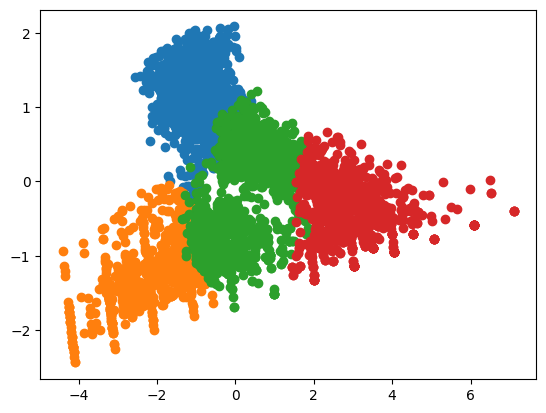

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

#### 더 심화과정으로는 각 축이 어떠한 변수로 구성되었는지 파악하지만, 여기서는 이정도만 소개하도록 하겠습니다.

### 테크닉 15 : 클러스터링 결과를 바탕으로 탈퇴회원의 경향을 파악하자

#### 탈퇴 회원을 집계하기 위해서 is_deleted 열을 추가하도록 하겠습니다.

In [10]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,791
1,0,1,543
2,1,1,771
3,2,0,1231
4,2,1,18
5,3,0,820
6,3,1,18


#### 결과를 보면 그룹2와 그룹3은 지속회원이 많고, 그룹1은 탈퇴회원들만 그룹 0은 골고루 표현되있음을 알 수 있습니다.

#### 테크닉 13의 결과까지 보면 그룹2는 회원 기간이 짧지만 초기에 의욕적이어서 전체적으로 이용률이 높으며, 그룹 3은 회원기간이 길고 이용율이 그룹2보다 낮지만 지속 회원이 많은 것을 생각하면 이용이 안정적이라고 생각할 수 있습니다.

#### 다음은 정기적/비정기적 이용 여부를 살펴봅시다.

In [11]:
customer_clustering.groupby(["cluster","routine_flg"],as_index=False).count()[["cluster","routine_flg","customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,227
1,0,1,1107
2,1,0,499
3,1,1,272
4,2,0,2
5,2,1,1247
6,3,0,51
7,3,1,787


#### 결과를 보면 그룹0, 그룹3에 정기적으로 이용하는 고객이 많다는 것을 알 수 있습니다.

### 테크닉 16 : 다음달의 이용횟수 예측을 위해 테이터를 준비하자

#### 다음달의 이용 횟수를 예측하는 경우에는 지도학습의 회귀분석을 이용합니다

#### 이번달이 2018년 10월이고 예측해야하는 다음 달이 2018년 11월이라고 가정해보면 여기서는 2018년 5월부터 10월까지 6개월의 데이터로 2018년 11월의 이용횟수를 정답데이터로 학습에 사용합니다.

In [12]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["연월"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["연월","customer_id"],as_index=False).count() #연월/아이디별 count 확인
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


#### uselog 데이터를 연원 회원마다 집계합니다.

In [13]:
year_months = list(uselog_months["연월"].unique()) # 컬럼 리스트화
predict_data = pd.DataFrame()
for i in range(6, len(year_months)): # for문으로 과거 6개월 전 데이터들 집계
    tmp = uselog_months.loc[uselog_months["연월"]==year_months[i]] #현재
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7): 
        tmp_before = uselog_months.loc[uselog_months["연월"]==year_months[i-j]] #1~6개월 전
        del tmp_before["연월"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


#### 결과의 count_pred 칼럼이 예측하고 싶은 달의 데이터이고, count_0은 최근 1개월 전, count_1은 최근으로부터 2개월 전..등등 입니다.
#### count 4, 5의 결측치는 가입기간이 짧아 데이터가 없는 경우입니다.

In [14]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


#### 결측치를 포함한 행들을 제거하여 가입한지 6개월이 지난 회원들만 남깁니다.

### 테크닉 17 : 특징이 되는 변수를 추가하자

#### 앞의 customer 데이터를 활용해서 start_date라는 컬럼을 추가해 줍니다.

In [15]:
predict_data = pd.merge(predict_data, customer[["customer_id","start_date"]], on="customer_id", how="left")
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [16]:
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None # period라는 컬럼 작성
for i in range(len(predict_data)): # 날짜비교함수를 통해 period의 값들 생성
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


#### relativedelta함수를 활용해 start_date와 end_date의 기간차이를 계산해 period로 나타냅니다. 

### 테크닉 18 : 다음달 이용횟수를 예측하는 모델을 구축하자

#### 여기서는 2018년 4월 이후의 회원들만 활용해 예측을 진행해 봅니다.오래전부터 있던 회원은 가입 시기 데이터가 존재하지 않거나 이용 횟수가 안정적일 가능성이 있기 때문에 오래된 회원은 빼고 모델을 구축합니다.
#### 여기서 사용할 회귀 모델은 선형회귀 모델입니다.

In [17]:
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection # 모델을 학습용과 평가용으로 나누어주는 라이브러리
model = linear_model.LinearRegression()
X = predict_data[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)

LinearRegression()

#### 학습용 데이터와 평가용 데이터로 나누는 이유를 설명하겠습니다. 머신러닝은 어디까지나 미지의 데이터를 예측하는 것이 목적입니다. 그러나 학습에 이용한 데이터를 완벽히 학습해버리면 미지의 데이터에 대응할 수 없게 되는데, 그 상태를 과적합이라고 부릅니다. 그래서 학습용 데이터로 학습을 진행하고, 모델에게는 미지의 데이터인 평가용 데이터를 제공해 정확도를 검증합니다.

In [18]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6057948469765593
0.6132776227626848


#### 정확도가 높은 예측 모델을 구축해도 그것이 어떤 모델인지를 이해하지 못하면 여러 가지 상황에서 설명할 수가 없습니다. 설명하지 못하면 현장에서도 납득하지 않아 도입이 지연되는 경우도 있습니다. 그렇기에 정확도가 높은 블랙박스 모델보다 정확도가 낮아도 설명이 가능한 모델이 좋습니다.

### 테크닉 19 : 모델에 기여하는 변수를 확인하자

In [19]:
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.324904
1,count_1,0.191091
2,count_2,0.158303
3,count_3,0.180651
4,count_4,0.103532
5,count_5,0.088796
6,period,0.090639


#### 코드를 실행하면 각 회귀들의 계수들을 확인할 수 있습니다. 또한 결과를 통해 count_0이 가장 크고 과거로 올라갈수록 기여도가 작아지는 경향이 있다는 것을 알 수 있습니다. 다시 말해서 이전 달의 이용 횟수가 다음 달의 이용 횟수에 영향을 미치고 있다는 점입니다.

### 테크닉 20 : 다음달의 이용횟수를 예측하자

#### 임의의 회원 2명의 이용 데이터를 만들어 봅시다.

#### 1번 회원은 6개월 전부터 1개월마다 7번, 8번,6번, 4번, 4번, 3번 방문했으며
#### 2번 회원은 6번, 4번, 3번, 3번, 2번, 2번 방문했습니다.
#### 두 회원의 재적 기간은 8개월이며, 두 회원의 다음 달 방문 횟수를 예측해 봅시다.

In [20]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

#### 회원의 이용 이력을 리스트에 저장하고 데이터를 작성합니다.

In [21]:
model.predict(x_pred)

array([3.89492984, 1.98466262])

#### 예측을 진행해보니 1번 회원은 3.8회, 2번 회원은 1.9회로 예측되었습니다.

#### 다른 모든 회원들도 비슷하게 자동으로 예측하는 모델을 시스템으로 만들 수 있습니다.
#### 이후 시스템을 활용하여 다음 달에 다양한 정책을 실시하는 데 활용할 수 있습니다.

In [22]:
uselog_months.to_csv("use_log_months.csv",index=False)

#### 다음챕터에도 쓸 수 있게 uselog_months 데이터로 저장해줍니다.